In [ ]:
# pip install transformers

In [ ]:
# pip install emoji

### 1. Import packages

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader
from transformers import AdamW
import pandas as pd
import torch
import random
import emoji
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import json
from collections import Counter
import re
import os
from string import punctuation
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

In [ ]:
SEED = 9999
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda', index=0)

### 2. Load and clean data

In [ ]:
def remove_punct(s):
    punct_pattern = re.compile(r'[^\w\s\#]')
    no_punct = punct_pattern.sub(r'', s)
    return no_punct

In [ ]:
def remove_emoji(string):
    allchars = [str for str in string]
    emoji_list = [c for c in allchars if c in emoji.UNICODE_EMOJI['en']]
    clean_text = ' '.join([str for str in string.split() if not any(i in str for i in emoji_list)])
    return clean_text

In [ ]:
def read_data(data, test=False):
    texts = []
    labels = []
    if test == False:
        data.dropna(subset=['tidyTweet', 'Label'], inplace=True)
    else:
        data.dropna(subset=['tidyTweet'], inplace=True)

    for i in tqdm(data.itertuples(), total=len(data)):
        line = getattr(i, 'tidyTweet')
        line = line.strip()
        if not line:
            continue
        line = remove_emoji(line)
        line = remove_punct(line).strip()
        texts.append(line)

        if test == False:
            label = getattr(i, 'Label')
            labels.append(label)
            if label == 1.0:
                texts.extend([line] * 2)
                labels.extend([label] * 2)

    if test == False:
        assert len(texts) == len(labels)
        return texts, labels
    else:
        return texts

In [ ]:
df = pd.read_csv('../dataset.csv')
df.groupby(['Label']).count()

,id,date,tweet,tidyTweet
Label,,,,
0.0,8865,8865,8865,8864
1.0,2884,2884,2884,2883


In [ ]:
texts, labels = read_data(df)

  0%|          | 0/11747 [00:00<?, ?it/s]

In [ ]:
Counter(labels)

Counter({0.0: 8864, 1.0: 8649})

### 3. Split train validation dataset

In [ ]:
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels,
                                                                    test_size=0.2,
                                                                    random_state=43,
                                                                    stratify=labels)

In [ ]:
len(train_labels),len(val_labels),len(train_texts),len(val_texts)

(14010, 3503, 14010, 3503)

In [ ]:
max([len(item) for item in texts])

286

### 4. Tokenization

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
train_encodings = tokenizer(train_texts,
                            truncation=True,
                            padding='max_length',
                            max_length=128)
val_encodings = tokenizer(val_texts,
                          truncation=True,
                          padding='max_length',
                          max_length=128)

In [ ]:
label_ids = {item: idx for idx, item in enumerate(set(sorted(labels)))}
label_ids

{0.0: 0, 1.0: 1}

### 5. Generate dataset

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        idx = int(idx)
        item = {
            key: torch.tensor(val[idx])
            for key, val in self.encodings.items()
        }
        if self.labels is not None:
            item['labels'] = torch.tensor(label_ids[self.labels[idx]])
        return item

    def __len__(self):
        return len(self.encodings.input_ids)

In [ ]:
train_dataset = Dataset(train_encodings, train_labels)
val_dataset = Dataset(val_encodings, val_labels)

### 6. Dataloader

In [ ]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
eval_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

### 7. Load pretrained model

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(label_ids))
model.to(device)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

### 8. Evaluation

In [ ]:
@torch.no_grad()
def eval_model(model, eval_loader):
    model.eval()
    labels = []
    preds = []
    eval_loss = 0
    for batch in eval_loader:
        input_ids = batch['input_ids'].to(device)
        batch_labels = batch['labels'].to(device)
        labels.extend(batch_labels.cpu().numpy())
        outputs = model(input_ids=input_ids, labels=batch_labels)
        eval_loss += outputs.loss.item()
        preds.extend(torch.argmax(outputs.logits, dim=-1).cpu().numpy())

    eval_loss = eval_loss / len(val_dataset)
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='macro')
    recall = recall_score(labels, preds, average='macro')
    f1 = f1_score(labels, preds, average='macro')
    return accuracy, precision, recall, f1, eval_loss

### 9. Train the model

In [ ]:
epoch = 4
lr = 5e-5
# path = './model_best_bert/e{}_bs{}_lr{:.0e}'.format(epoch, batch_size, lr)
path = './model_best_bert
best_acc = 0
train_losses = []
eval_stats = {'Epoch':[], 'Loss':[], 'Accuracy':[], 'Precision':[], 'Recall':[], 'F1':[]}

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [{'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
                                 'weight_decay_rate': 0.01}, 
                                {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
                                 'weight_decay_rate': 0.0}]

optim = AdamW(optimizer_grouped_parameters, lr=lr)
writer = SummaryWriter(comment='-bert-ep{}-bs{}-lr{}'.format(epoch, batch_size, lr))

for e in tqdm(range(epoch), desc='Epoch'):
    train_loss = 0
    model.train()
    for idx, batch in tqdm(enumerate(train_loader),
                           total=len(train_texts) // batch_size,
                           desc='Batch'):
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids=input_ids, labels=labels)
        loss = outputs.loss
        train_loss += loss.item()
        loss.backward()
        optim.step()
    
    train_loss = train_loss / len(train_dataset)
    train_losses.append(train_loss)

    accuracy, precision, recall, f1, eval_loss = eval_model(model, eval_loader)

    eval_stats['Epoch'].append(e)
    eval_stats['Loss'].append(eval_loss)
    eval_stats['Accuracy'].append(accuracy)
    eval_stats['Precision'].append(precision)
    eval_stats['Recall'].append(recall)
    eval_stats['F1'].append(f1)

    writer.add_scalar('train_loss', train_loss, e)
    writer.add_scalar('accuracy', accuracy, e)
    writer.add_scalar('precision', precision, e)
    writer.add_scalar('recall', recall, e)
    writer.add_scalar('f1', f1, e)

    print(f'Epoch:{e+1}/{epoch}')
    print('Train loss:', train_loss)
    print('Validation loss:', eval_loss)
    print('Accuracy:', accuracy)
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1:', f1)
    print()

    if accuracy > best_acc:
        model.save_pretrained(path)  
        tokenizer.save_pretrained(path)
        best_acc = accuracy

print('Best Accuracy:', best_acc)
print('Finished Training.')

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Batch:   0%|          | 0/437 [00:00<?, ?it/s]

Epoch:1/4
Train loss: 0.01791003353675717
Validation loss: 0.01402781608102664
Accuracy: 0.8053097345132744
Precision: 0.8052929652983063
Recall: 0.8052523563145317
F1: 0.8052684586296771



Batch:   0%|          | 0/437 [00:00<?, ?it/s]

Epoch:2/4
Train loss: 0.009807119129237577
Validation loss: 0.009616978266580834
Accuracy: 0.879246360262632
Precision: 0.8823155003347379
Recall: 0.8798064415167787
F1: 0.8790997154483983



Batch:   0%|          | 0/437 [00:00<?, ?it/s]

Epoch:3/4
Train loss: 0.0038158307982067564
Validation loss: 0.009203688758647412
Accuracy: 0.9040822152440765
Precision: 0.9120257863174885
Recall: 0.9049509501872989
F1: 0.9037395578167201



Batch:   0%|          | 0/437 [00:00<?, ?it/s]

Epoch:4/4
Train loss: 0.001999915341524571
Validation loss: 0.013145999894819063
Accuracy: 0.8960890665144162
Precision: 0.9065846925218483
Recall: 0.8970897763172051
F1: 0.8955698607698608

Best Accuracy: 0.9040822152440765
Finished Training.


In [ ]:
train_losses

[0.01791003353675717,
 0.009807119129237577,
 0.0038158307982067564,
 0.001999915341524571]

In [ ]:
eval_stats

{'Accuracy': [0.8053097345132744,
  0.879246360262632,
  0.9040822152440765,
  0.8960890665144162],
 'Epoch': [0, 1, 2, 3],
 'F1': [0.8052684586296771,
  0.8790997154483983,
  0.9037395578167201,
  0.8955698607698608],
 'Loss': [0.01402781608102664,
  0.009616978266580834,
  0.009203688758647412,
  0.013145999894819063],
 'Precision': [0.8052929652983063,
  0.8823155003347379,
  0.9120257863174885,
  0.9065846925218483],
 'Recall': [0.8052523563145317,
  0.8798064415167787,
  0.9049509501872989,
  0.8970897763172051]}

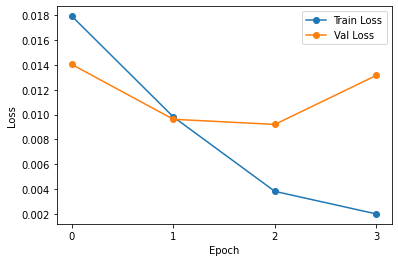

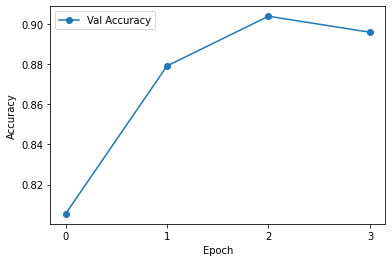

In [ ]:
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(eval_stats['Loss'], label='Val Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(eval_stats['Epoch'])
plt.legend()
plt.show()

plt.plot(eval_stats['Accuracy'], label='Val Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(eval_stats['Epoch'])
plt.legend()
plt.show()

In [ ]:
# output training results
if not os.path.exists(path):
    os.makedirs(path)

f = open(f'{path}/train_losses_e{epoch}_bs{batch_size}_lr{lr:.0e}', 'w+')
f.write(json.dumps(train_losses))
f.close()
f = open(f'{path}/eval_stats_e{epoch}_bs{batch_size}_lr{lr:.0e}', 'w+')
f.write(json.dumps(eval_stats))
f.close()

### 10. Prediction of test dataset

In [ ]:
trained_bert_model = BertForSequenceClassification.from_pretrained(path)
trained_bert_tokenizer = BertTokenizer.from_pretrained(path)
trained_bert_model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
def test_model(test_data, model, tokenizer):
    for data in test_data:
        print(data)
        test_df = pd.read_csv('../' + data)
        test_texts = read_data(test_df, test=True)
        test_encodings = tokenizer(test_texts,
                                truncation=True,
                                padding='max_length',
                                max_length=128)
        test_dataset = Dataset(test_encodings)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        model.eval()
        test_predictions = []
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            with torch.no_grad():
                outputs = model(input_ids)
            test_predictions.extend(torch.argmax(outputs.logits, dim=-1).cpu().numpy())

        test_pred_uniq = np.unique(test_predictions, return_counts=True)
        for l in test_pred_uniq[0]:
            print('Test Label:', l)
            print('Count:', test_pred_uniq[1][np.where(test_pred_uniq[0]==l)].item())
            print('Percentage:', test_pred_uniq[1][np.where(test_pred_uniq[0]==l)].item() / np.sum(test_pred_uniq[1]))
        test_df_labeled = pd.concat((test_df, pd.Series(test_predictions, name='label')), axis=1)
        test_df_labeled.to_csv(path + '/' + data.split('.')[0] + '_labeled.csv', index=False)
        # print(test_df_labeled.head())
        print()

In [ ]:
test_data = ['test_truckers_data.csv', 'test_covid_data.csv']
test_model(test_data, trained_bert_model, trained_bert_tokenizer)

test_truckers_data.csv


  0%|          | 0/1803 [00:00<?, ?it/s]

Test Label: 0
Count: 1692
Percentage: 0.9384359400998337
Test Label: 1
Count: 111
Percentage: 0.06156405990016639

test_covid_data.csv


  0%|          | 0/1954 [00:00<?, ?it/s]

Test Label: 0
Count: 1618
Percentage: 0.8280450358239508
Test Label: 1
Count: 336
Percentage: 0.17195496417604914



In [ ]:
# # download trained model and dataset for google colab
# from google.colab import files
# files.download('/content'+ path.split('.')[1] + '/test_covid_data_labeled.csv')
# files.download('/content'+ path.split('.')[1] + '/test_truckers_data_labeled.csv')
# !zip -r /content/model_best_bert.zip /content/model_best_bert
# files.download("/content/model_best_bert.zip")